# Benchmark model - Impairment - Sequential Timewise Exploration, calibration, test

This notebook uses as inputs the outputs from the pipeline ('05_preproc_pipeline_1.ipynb' notebook) and performs model calibration and general exploration for the transaction credit events prediction.

In [1]:
import pandas as pd
import numpy as np
import pickle
from os import environ

from sklearn.model_selection import cross_val_predict, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from scripts_viz.visualization_utils import *
from scripts_ml.models_utils import *

from bokeh.io import show, output_notebook
output_notebook()

import datetime as dt

Loading BokehJS ...

### TRAIN Data import

In [2]:
#importing data
preproc_folder = "enriched_time_seq"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'
prefix_time_seq = 'time_2018-02-20_p180_bg_'
valid_code = '_val_12000_3000_'
trainfile = '_traindata'
testfile = '_testdata'
postfix_time_seq_val = '_190812_175'
postfix_time_seq = '_190812_1645'
preproc_folder = "enriched_time_seq"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'
indexfile = '_fold_indexes'
expname = preproc_folder+"_p90"

[X_train, y_train, feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+trainfile+postfix_time_seq+'.pkl') 
[X_test, y_test, feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+testfile+postfix_time_seq+'.pkl') 
[val_X_train, val_y_train, val_feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+valid_code+trainfile+postfix_time_seq_val+'.pkl') 
[val_X_test, val_y_test, val_feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+valid_code+testfile+postfix_time_seq_val+'.pkl') 
indexes = pd.read_pickle(datafolder+prefix_time_seq+valid_code+indexfile+postfix_time_seq_val+'.pkl')

In [3]:
#recombining folds for grid search

val_X_all = []
val_y_all = []

count=0
for idx in indexes:
    val_X_all.append(val_X_train[idx[0]])
    val_y_all.append(val_y_train[idx[0]])
    if count==0:
        test_idx = np.array(range(0, len(idx[1])))
    else:
        test_idx+=len(idx[1])
    val_X_all.append(val_X_test[test_idx])
    val_y_all.append(val_y_test[test_idx])
    count+=1
        

In [4]:
val_X_all = np.concatenate(val_X_all, axis=0)
val_y_all = np.concatenate(val_y_all, axis=0)

In [5]:
val_X_all.shape

(150079, 35)

In [6]:
val_X_all_df = pd.DataFrame(val_X_all, columns=feature_labels)
val_X_all_df.head()

,currency_Schweizer Franken,currency_Euro,currency_US-Dollar,currency_Britisches Pfund,has_purchase,dd_value_date,cd_lent_c,cd_repaid_c,cd_impaired1_c,cd_pastdue90_c,...,flow_shock_p90,p90_c_node_eff,p90_energy,p90_d_node_flow,flow_shock_p180,p180_d_node_flow,p180_energy,invoice_amount,purchase_amount,invoice_date
0,0.385668,-0.373966,-0.028785,-0.077437,-2.28681,0.070378,-0.631417,-0.459671,-0.157006,-0.106712,...,-0.159044,-0.414296,-0.562164,-0.162827,-0.563756,-0.161759,-0.562042,-0.678257,-2.213455,-4.028431
1,0.385668,-0.373966,-0.028785,-0.077437,-2.28681,0.070378,-0.620554,-0.459671,-0.157006,-0.106712,...,-0.159044,-0.414296,-0.562164,-0.162827,-0.563756,-0.161759,-0.562042,-0.074416,-2.213455,-4.028431
2,0.385668,-0.373966,-0.028785,-0.077437,-2.28681,0.070378,-0.609692,-0.459671,-0.157006,-0.106712,...,-0.159044,-0.414296,-0.562164,-0.162827,-0.563756,-0.161759,-0.562042,-0.404354,-2.213455,-4.028431
3,0.385668,-0.373966,-0.028785,-0.077437,-2.28681,0.070378,-0.631417,-0.459671,-0.157006,-0.106712,...,6.287571,-0.415072,4.444293,-0.162827,4.421404,-0.161759,4.444207,0.881624,-2.213455,-4.028431
4,0.385668,-0.373966,-0.028785,-0.077437,-2.28681,0.070378,-0.631417,-0.459671,-0.157006,-0.106712,...,6.287571,-0.415072,4.444293,-0.162827,4.421404,-0.161759,4.444207,0.412908,-2.213455,-4.028431


In [7]:
val_X_all_df.columns

Index(['currency_Schweizer Franken', 'currency_Euro', 'currency_US-Dollar',
       'currency_Britisches Pfund', 'has_purchase', 'dd_value_date',
       'cd_lent_c', 'cd_repaid_c', 'cd_impaired1_c', 'cd_pastdue90_c',
       'cd_trend_a', 'c_lent_c', 'c_repaid_c', 'c_impaired1_c',
       'c_pastdue90_c', 'c_trend_a', 'd_repaid_c', 'd_impaired1_c',
       'd_pastdue90_c', 'd_trend_a', 'd_we_payment_share', 'flow_shock_imp1',
       'imp_c_node_eff', 'imp_energy', 'imp_d_node_flow', 'flow_shock_p90',
       'p90_c_node_eff', 'p90_energy', 'p90_d_node_flow', 'flow_shock_p180',
       'p180_d_node_flow', 'p180_energy', 'invoice_amount', 'purchase_amount',
       'invoice_date'],
      dtype='object')

In [8]:
val_X_all_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
currency_Schweizer Franken,150079.0,-0.022530,1.027372,-4.324862,0.274352,0.456573,0.480253,0.482354
currency_Euro,150079.0,0.023003,1.029002,-0.470768,-0.467463,-0.440488,-0.356332,4.620213
currency_US-Dollar,150079.0,0.004745,1.096302,-0.093501,-0.065331,-0.057102,-0.057102,34.740467
currency_Britisches Pfund,150079.0,-0.000528,0.941540,-0.082437,-0.082437,-0.077437,-0.062033,25.800516
has_purchase,150079.0,0.026097,0.977095,-2.964444,0.337331,0.386840,0.437290,0.483666
dd_value_date,150079.0,-0.035101,0.940283,-0.395081,-0.215889,-0.134786,-0.012911,106.619148
cd_lent_c,150079.0,0.055916,1.067541,-0.690596,-0.577103,-0.429622,0.128978,4.632927
cd_repaid_c,150079.0,0.059539,1.070158,-0.636315,-0.479930,-0.402250,-0.018526,4.938747
cd_impaired1_c,150079.0,0.002179,1.004143,-0.216306,-0.173572,-0.164818,-0.157006,10.948879
cd_pastdue90_c,150079.0,0.034303,1.223104,-0.240687,-0.106712,-0.020417,-0.012911,77.453209


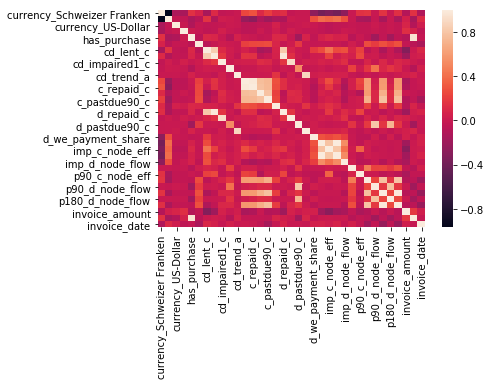

In [9]:
sns.heatmap(val_X_all_df.corr())

### SGD Classifier

In [10]:
#Linear model Stochastic Gradient Descent
sgd_clf = SGDClassifier(random_state=42, max_iter=250, loss='log', tol=0.0001) 
sgd_clf_diag = model_diag_seq(sgd_clf, val_X_train, val_y_train, specify_idxs=True, idx_tuples=indexes, X_test=val_X_test, y_test=val_y_test)

Fold 1: train  on 12079 from index 0 to 12078, test on 3000 from 0 to 2999
Fold 1 AUC: 0.5473883592925634
Fold 2: train  on 12000 from index 3079 to 15078, test on 3000 from 3000 to 5999
Fold 2 AUC: 0.6544264
Fold 3: train  on 12000 from index 6079 to 18078, test on 3000 from 6000 to 8999
Fold 3 AUC: 0.5025137878615763
Fold 4: train  on 12000 from index 9079 to 21078, test on 3000 from 9000 to 11999
Fold 4 AUC: 0.6315608986333145
Fold 5: train  on 12000 from index 12079 to 24078, test on 3000 from 12000 to 14999
Fold 5 AUC: 0.5367395422339902
Fold 6: train  on 12000 from index 15079 to 27078, test on 3000 from 15000 to 17999
Fold 6 AUC: 0.39650754293609525
Fold 7: train  on 12000 from index 18079 to 30078, test on 3000 from 18000 to 20999
Fold 7 AUC: 0.42268134017308934
Fold 8: train  on 12000 from index 21079 to 33078, test on 3000 from 21000 to 23999
Fold 8 AUC: 0.4985467360424901
Fold 9: train  on 12000 from index 24079 to 36078, test on 3000 from 24000 to 26999
Fold 9 AUC: 0.422511

In [11]:
sgd_clf.fit(X_train, y_train)
y_score_sgd = sgd_clf.predict(X_test)
cm = confusion_matrix(y_test, y_score_sgd)
print(cm)
sgd_test_diag = model_oostest(sgd_clf,X_test, y_test)
sgd_test_auc = plot_rocs([sgd_clf_diag, sgd_test_diag], p_width=600, p_height=600, model_appendix=['SGD - seq_valid','SGD - test'])
show(sgd_test_auc)

[[5885 9601]
 [  10   44]]
Confusion matrix: 
[[0.38002 0.61998]
 [0.00065 0.00284]]
AUC 0.698


In [12]:
#save_sk_model(sgd_clf, "../data/models/", 'sgd', 'benchmark')

In [13]:
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

# max Number of iterations
max_iter = [100, 180, 200, 250, 300, 320, 350] 
# learning rate
learning_rate = ['constant', 'optimal', 'adaptive']
#eta
eta0 = [0.00001, 0.0001, 0.001, 0.01]
#loss
loss = ['log', 'hinge', 'perceptron']

param_grid = {'max_iter': max_iter,
               'learning_rate': learning_rate,
                  'eta0': eta0,
                  'loss':loss}

sgd = SGDClassifier(tol=0.0001)

sgd_gsearch = GridSearchCV(estimator = sgd, param_grid = param_grid, #param_distributions = sgd_random_grid, 
                           cv = rolling_window(val_X_all.shape[0],ntrain = 12000, ntest = 3000, gen_for_grid_search=True),   
                                 verbose=2, n_jobs =7, scoring=scoring, refit='AUC')
# Fit the random search model
sgd_gsearch.fit(val_X_all, val_y_all)

Preparing fold 0 with 12079 train observations and 3000 test observations, starti=3079...
Preparing fold 1 with 12000 train observations and 3000 test observations, starti=6079...
Preparing fold 2 with 12000 train observations and 3000 test observations, starti=9079...
Preparing fold 3 with 12000 train observations and 3000 test observations, starti=12079...
Preparing fold 4 with 12000 train observations and 3000 test observations, starti=15079...
Preparing fold 5 with 12000 train observations and 3000 test observations, starti=18079...
Preparing fold 6 with 12000 train observations and 3000 test observations, starti=21079...
Preparing fold 7 with 12000 train observations and 3000 test observations, starti=24079...
Preparing fold 8 with 12000 train observations and 3000 test observations, starti=27079...
Preparing fold 9 with 12000 train observations and 3000 test observations, starti=30079...
Preparing fold 10 with 12000 train observations and 3000 test observations, starti=33079...
P

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    3.0s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:   15.2s
[Parallel(n_jobs=7)]: Done 351 tasks      | elapsed:   42.6s
[Parallel(n_jobs=7)]: Done 634 tasks      | elapsed:   50.5s
[Parallel(n_jobs=7)]: Done 1314 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 2112 tasks      | elapsed:  1.7min
[Parallel(n_jobs=7)]: Done 2639 tasks      | elapsed:  2.3min
[Parallel(n_jobs=7)]: Done 3379 tasks      | elapsed:  2.9min
[Parallel(n_jobs=7)]: Done 4557 tasks      | elapsed:  3.4min
[Parallel(n_jobs=7)]: Done 5509 tasks      | elapsed:  4.3min
[Parallel(n_jobs=7)]: Done 6360 tasks      | elapsed:  4.7min
[Parallel(n_jobs=7)]: Done 7968 tasks      | elapsed:  5.6min
[Parallel(n_jobs=7)]: Done 8981 tasks      | elapsed:  6.1min
[Parallel(n_jobs=7)]: Done 11049 tasks      | elapsed:  7.0min
[Parallel(n_jobs=7)]: Done 11579 out of 11592 | elapsed:  7.

GridSearchCV(cv=<generator object rolling_window at 0x000002D5BF0EB308>,
             error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5...
                                     verbose=0, warm_start=False),
             iid='warn', n_jobs=7,
             param_grid={'eta0': [1e-05, 0.0001, 0.001, 0.01],
                         'learning_rate': ['constant', 'optimal', 'adaptive'],
                         'loss': ['log', 'hinge', 'perceptron'],
                         'max_iter': [100, 180, 200, 250, 300, 320, 3

In [14]:
sgd_gsearch.best_params_

{'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'log', 'max_iter': 320}

In [15]:
#Linear model Stochastic Gradient Descent
sgd_gs = SGDClassifier(random_state=42, max_iter=320, loss='log', learning_rate='constant', eta0=0.01, tol=0.0001) 
sgd_gs_diag = model_diag_seq(sgd_clf, val_X_train, val_y_train, specify_idxs=True, idx_tuples=indexes, X_test=val_X_test, y_test=val_y_test)

Fold 1: train  on 12079 from index 0 to 12078, test on 3000 from 0 to 2999
Fold 1 AUC: 0.5473883592925634
Fold 2: train  on 12000 from index 3079 to 15078, test on 3000 from 3000 to 5999
Fold 2 AUC: 0.6544264
Fold 3: train  on 12000 from index 6079 to 18078, test on 3000 from 6000 to 8999
Fold 3 AUC: 0.5025137878615763
Fold 4: train  on 12000 from index 9079 to 21078, test on 3000 from 9000 to 11999
Fold 4 AUC: 0.6315608986333145
Fold 5: train  on 12000 from index 12079 to 24078, test on 3000 from 12000 to 14999
Fold 5 AUC: 0.5367395422339902
Fold 6: train  on 12000 from index 15079 to 27078, test on 3000 from 15000 to 17999
Fold 6 AUC: 0.39650754293609525
Fold 7: train  on 12000 from index 18079 to 30078, test on 3000 from 18000 to 20999
Fold 7 AUC: 0.42268134017308934
Fold 8: train  on 12000 from index 21079 to 33078, test on 3000 from 21000 to 23999
Fold 8 AUC: 0.4985467360424901
Fold 9: train  on 12000 from index 24079 to 36078, test on 3000 from 24000 to 26999
Fold 9 AUC: 0.422511

In [16]:
sgd_gs.fit(X_train, y_train)
y_score_sgd_gs = sgd_gs.predict(X_test)
cm = confusion_matrix(y_test, y_score_sgd_gs)
print(cm)
sgd_test_diag_gs = model_oostest(sgd_gs,X_test, y_test)
sgd_test_auc_gs = plot_rocs([sgd_gs_diag, sgd_test_diag_gs], p_width=600, p_height=600, model_appendix=['SGD - seq_valid','SGD - test'])
show(sgd_test_auc_gs)

[[5823 9663]
 [  10   44]]
Confusion matrix: 
[[0.37602 0.62398]
 [0.00065 0.00284]]
AUC 0.691


### Random Forest Classifier

In [17]:
#random forest - benchmark
n_estimators = 200
max_leaf_nodes = 40
rf_clf = RandomForestClassifier(random_state=42,
                               n_estimators=n_estimators,
                               max_leaf_nodes=max_leaf_nodes,
                               class_weight="balanced",
                               n_jobs=7)

rf_clf_diag = model_diag_seq(rf_clf, val_X_train, val_y_train, specify_idxs=True, idx_tuples=indexes, X_test=val_X_test, y_test=val_y_test)

Fold 1: train  on 12079 from index 0 to 12078, test on 3000 from 0 to 2999
Fold 1 AUC: 0.4567716582204896
Fold 2: train  on 12000 from index 3079 to 15078, test on 3000 from 3000 to 5999
Fold 2 AUC: 0.43929159999999995
Fold 3: train  on 12000 from index 6079 to 18078, test on 3000 from 6000 to 8999
Fold 3 AUC: 0.5928289079860468
Fold 4: train  on 12000 from index 9079 to 21078, test on 3000 from 9000 to 11999
Fold 4 AUC: 0.6564976106702948
Fold 5: train  on 12000 from index 12079 to 24078, test on 3000 from 12000 to 14999
Fold 5 AUC: 0.6323441001257036
Fold 6: train  on 12000 from index 15079 to 27078, test on 3000 from 15000 to 17999
Fold 6 AUC: 0.5471172435214292
Fold 7: train  on 12000 from index 18079 to 30078, test on 3000 from 18000 to 20999
Fold 7 AUC: 0.7216231391148883
Fold 8: train  on 12000 from index 21079 to 33078, test on 3000 from 21000 to 23999
Fold 8 AUC: 0.6348804579421936
Fold 9: train  on 12000 from index 24079 to 36078, test on 3000 from 24000 to 26999
Fold 9 AUC: 

In [18]:
rf_clf.fit(X_train, y_train)
y_score_rf = rf_clf.predict(X_test)
cm = confusion_matrix(y_test, y_score_rf)
print(cm)
rf_test_diag = model_oostest(rf_clf,X_test, y_test)
rf_test_auc = plot_rocs([rf_clf_diag, rf_test_diag], p_width=600, p_height=600, model_appendix=['RF - seq_valid','RF - test'])
show(rf_test_auc)

[[12995  2491]
 [   31    23]]
Confusion matrix: 
[[0.83915 0.16085]
 [0.002   0.00149]]
AUC 0.792


### Randomized Grid Search

In [19]:
# Number of trees in random forest
n_estimators = [150, 180, 200, 250, 280, 300, 350] 
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 10, 20]
# Maximum number of levels in tree
max_depth = [100,200, None]
#Max leaf nodes
max_leaf_nodes = [10,20,40,60]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'max_leaf_nodes':max_leaf_nodes}

In [20]:
rf = RandomForestClassifier() #base model
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 80, 
                               cv = rolling_window(X_train.shape[0],ntrain = 12000, ntest = 3000, gen_for_grid_search=True), 
                               verbose=2, random_state=42, n_jobs =7, refit='AUC', scoring=scoring)
# Fit the random search model
rf_random.fit(val_X_all, val_y_all)

Preparing fold 0 with 12079 train observations and 3000 test observations, starti=3079...
Preparing fold 1 with 12000 train observations and 3000 test observations, starti=6079...
Preparing fold 2 with 12000 train observations and 3000 test observations, starti=9079...
Preparing fold 3 with 12000 train observations and 3000 test observations, starti=12079...
Preparing fold 4 with 12000 train observations and 3000 test observations, starti=15079...
Preparing fold 5 with 12000 train observations and 3000 test observations, starti=18079...
Preparing fold 6 with 12000 train observations and 3000 test observations, starti=21079...
Preparing fold 7 with 12000 train observations and 3000 test observations, starti=24079...
Preparing fold 8 with 12000 train observations and 3000 test observations, starti=27079...
Preparing fold 9 with 12000 train observations and 3000 test observations, starti=30079...
Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   19.3s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:  1.8min
[Parallel(n_jobs=7)]: Done 351 tasks      | elapsed:  3.6min
[Parallel(n_jobs=7)]: Done 634 tasks      | elapsed:  6.4min
[Parallel(n_jobs=7)]: Done 800 out of 800 | elapsed:  8.8min finished


RandomizedSearchCV(cv=<generator object rolling_window at 0x000002D5BFDA4830>,
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fracti...
                   param_distributions={'bootstrap': [True, False],
    

In [21]:
rf_random.best_params_

{'n_estimators': 280,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 60,
 'max_features': 20,
 'max_depth': 200,
 'bootstrap': True}

In [22]:
# Number of trees in random forest
n_estimators = [250, 280, 300] 
# Number of features to consider at every split
max_features = ['auto',20]
# Maximum number of levels in tree
max_depth = [None, 200]
#Max leaf nodes
max_leaf_nodes = [60,80]
# Minimum number of samples required to split a node
min_samples_split = [5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'max_leaf_nodes':max_leaf_nodes}

In [23]:
rf = RandomForestClassifier() #base model
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           cv = rolling_window(val_X_all.shape[0],ntrain = 12000, ntest = 3000, gen_for_grid_search=True),   
                                 verbose=2, n_jobs =7, scoring=scoring, refit='AUC')
# Fit the random search model
rf_grid.fit(val_X_all, val_y_all)

Preparing fold 0 with 12079 train observations and 3000 test observations, starti=3079...
Preparing fold 1 with 12000 train observations and 3000 test observations, starti=6079...
Preparing fold 2 with 12000 train observations and 3000 test observations, starti=9079...
Preparing fold 3 with 12000 train observations and 3000 test observations, starti=12079...
Preparing fold 4 with 12000 train observations and 3000 test observations, starti=15079...
Preparing fold 5 with 12000 train observations and 3000 test observations, starti=18079...
Preparing fold 6 with 12000 train observations and 3000 test observations, starti=21079...
Preparing fold 7 with 12000 train observations and 3000 test observations, starti=24079...
Preparing fold 8 with 12000 train observations and 3000 test observations, starti=27079...
Preparing fold 9 with 12000 train observations and 3000 test observations, starti=30079...
Preparing fold 10 with 12000 train observations and 3000 test observations, starti=33079...
P

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   12.5s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done 351 tasks      | elapsed:  2.7min
[Parallel(n_jobs=7)]: Done 634 tasks      | elapsed:  6.6min
[Parallel(n_jobs=7)]: Done 999 tasks      | elapsed: 16.5min
[Parallel(n_jobs=7)]: Done 1444 tasks      | elapsed: 22.5min
[Parallel(n_jobs=7)]: Done 1971 tasks      | elapsed: 32.7min
[Parallel(n_jobs=7)]: Done 2208 out of 2208 | elapsed: 40.0min finished


GridSearchCV(cv=<generator object rolling_window at 0x000002D5BF3A16D0>,
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_lea...
                                              warm_start=False),
             iid='warn', n_jobs=7,
             param_grid={'bootstrap': [True], 'max_depth': [None, 200],
                         'max_features': ['auto', 20],
         

In [24]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 200,
 'max_features': 'auto',
 'max_leaf_nodes': 80,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 280}

In [25]:
#optimized params 
rf_opt = {'n_estimators': 180,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 80,
 'max_features': 'auto',
 'max_depth': 200,
 'bootstrap': True}

In [26]:
#random_forest from rand
n_estimators=rf_opt['n_estimators']
min_samples_split=rf_opt['min_samples_split']
min_samples_leaf=rf_opt['min_samples_leaf']
max_leaf_nodes=rf_opt['max_leaf_nodes']
max_features=rf_opt['max_features']
max_depth=rf_opt['max_depth']
bootstrap=rf_opt['bootstrap']




rf_opt_clf = RandomForestClassifier(random_state=42,
                               n_estimators=n_estimators,
                                max_features=max_features,
                                min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               class_weight="balanced", bootstrap=bootstrap,
                               n_jobs=7)

rf_opt_diag = model_diag_seq(rf_opt_clf, val_X_train, val_y_train, specify_idxs=True, idx_tuples=indexes, X_test=val_X_test, y_test=val_y_test)

Fold 1: train  on 12079 from index 0 to 12078, test on 3000 from 0 to 2999
Fold 1 AUC: 0.43944715082516245
Fold 2: train  on 12000 from index 3079 to 15078, test on 3000 from 3000 to 5999
Fold 2 AUC: 0.6046136000000001
Fold 3: train  on 12000 from index 6079 to 18078, test on 3000 from 6000 to 8999
Fold 3 AUC: 0.6110795566952019
Fold 4: train  on 12000 from index 9079 to 21078, test on 3000 from 9000 to 11999
Fold 4 AUC: 0.6106821438727773
Fold 5: train  on 12000 from index 12079 to 24078, test on 3000 from 12000 to 14999
Fold 5 AUC: 0.7459187007752696
Fold 6: train  on 12000 from index 15079 to 27078, test on 3000 from 15000 to 17999
Fold 6 AUC: 0.6836927184024078
Fold 7: train  on 12000 from index 18079 to 30078, test on 3000 from 18000 to 20999
Fold 7 AUC: 0.7034538618697035
Fold 8: train  on 12000 from index 21079 to 33078, test on 3000 from 21000 to 23999
Fold 8 AUC: 0.5845209053853756
Fold 9: train  on 12000 from index 24079 to 36078, test on 3000 from 24000 to 26999
Fold 9 AUC: 

In [27]:
rf_opt_clf.fit(X_train, y_train)
y_score_rf_opt = rf_opt_clf.predict(X_test)
cm = confusion_matrix(y_test, y_score_rf_opt)
print(cm)
rf_opt_test_diag = model_oostest(rf_opt_clf,X_test, y_test)
rf_opt_test_auc = plot_rocs([rf_opt_diag, rf_opt_test_diag], p_width=600, p_height=600, model_appendix=['RF - val_seq','RF - test'])
show(rf_opt_test_auc)

[[15063   423]
 [   54     0]]
Confusion matrix: 
[[0.97269 0.02731]
 [0.00349 0.     ]]
AUC 0.791
